This notebook implements reclassification of irrigated croplands based on kmeans clustering, phenology and external layers information. More information on vegetation phenology in DE Africa: https://docs.digitalearthafrica.org/en/latest/sandbox/notebooks/Real_world_examples/Phenology_optical.html.

In [1]:
%matplotlib inline
import os
import datacube
import warnings
import numpy as np
import geopandas as gpd
import pandas as pd
import xarray as xr
import rioxarray
from rasterio.enums import Resampling
from odc.io.cgroups import get_cpu_quota
from odc.algo import xr_geomedian
from datacube.utils.cog import write_cog
from deafrica_tools.datahandling import load_ard
from deafrica_tools.bandindices import calculate_indices
from deafrica_tools.classification import collect_training_data
from deafrica_tools.spatial import xr_vectorize
from sklearn.cluster import KMeans
from skimage.measure import label,regionprops
from odc.algo import xr_reproject
import time
import matplotlib.pyplot as plt
from deafrica_tools.temporal import xr_phenology

# get number of CPUs available
ncpus=round(get_cpu_quota()) 
print('ncpus = '+str(ncpus))

# parameters
crs='epsg:32735' # output crs: WGS84/UTM Zone 35S
class_name = 'LC_Class_I' # class label in integer format
fill_nan_value=-999 # value to replace nans in query results

# file paths of produced and external data
lesotho_tiles_shp='Data/Lesotho_boundaries_projected_epsg32735_tiles.shp' # Lesotho tiles
crops_shp='Data/signatures_crop.shp' # crop signature data
lacowiki_irrigated_shp='Data/lacowiki_irrigated.shp' # irrigated crops locations collected using laco wiki
manual_irrigated_shp='Data/manual_irrigated.shp' # manually selected irrigated cropland points
classification2021_raster='Results/Land_cover_prediction_balanced_newest_DEAfrica_2021_mosaic.tif' # land cover map of 2021
hand_raster='Data/hand_Lesotho.tif' # Hydrologically adjusted elevations, i.e. height above the nearest drainage (hand)
path_crop_signatures = "Results/signatures_crop_masked.txt" # crop signature file

# import Lesotho tiles and get bounding boxes
lesotho_tiles=gpd.read_file(lesotho_tiles_shp).to_crs(crs) # get bounding boxes of tiles covering Lesotho
tile_bboxes=lesotho_tiles.bounds

# load produced land cover map and hydrology layer
landcover2021=rioxarray.open_rasterio(classification2021_raster).astype(np.uint8).squeeze() # import land cover map of 2021
hand=xr.open_dataset(hand_raster,engine="rasterio").squeeze() # import hand layer

ncpus = 62
Lethoso bbox:  27.011232336601374 -30.67784748254426 29.4573649650311 -28.57059736718119


In [2]:
# extract or load signatures of the reference crop locations (only geomedians of NDVI)
if os.path.exists(path_crop_signatures): # if crop signature file exists, load data
    # read in generated signature data
    crop_signatures_data= pd.read_csv(path_crop_signatures,delimiter=' ')
    column_names_crops=list(crop_signatures_data.columns)
    crop_signatures_data=crop_signatures_data.to_numpy()
else: # otherwise extract crop signature data using crop location points
    # import crop refrence points from various sources
    crops=gpd.read_file(crops_shp).to_crs('epsg:4326')
    lacowiki_irrigated=gpd.read_file(lacowiki_irrigated_shp).to_crs('epsg:4326')
    manual_irrigated=gpd.read_file(manual_irrigated_shp).to_crs('epsg:4326')
    
    # subset,assign class and merge crop signature geodataframes
    crops=crops.loc[crops[class_name]==2]
    lacowiki_irrigated=lacowiki_irrigated.loc[lacowiki_irrigated['ValValue']=='14']
    lacowiki_irrigated[class_name]=14
    manual_irrigated[class_name]=14
    crop_signatures=pd.concat([crops,lacowiki_irrigated,manual_irrigated]).reset_index(drop=True)
    crop_signatures=crop_signatures[[class_name,'geometry']] # drop unused columns
    print('Cropland reference points:\n',crop_signatures)
    
    # filtering out training points not classified as croplands on 2021 land cover map
    indices_remove=[] # indices of rows to remove
    for i in range(len(crop_signatures)):
        lc_class=landcover2021.sel({'x':[crop_signatures.iloc[i].geometry.x],
                                    'y':[crop_signatures.iloc[i].geometry.y]}, 
                                   method="nearest").to_numpy().squeeze() # identify pixel values corresponding to the crop points
        if lc_class!=2:
            indices_remove.append(i)
    crop_signatures_filtered=crop_signatures.drop(indices_remove).reset_index(drop=True) # remove these points
    print('Cropland reference points after filtering:\n',crop_signatures_filtered)
    
    # extract crop features (only geomedians of NDVI) using the crop reference locations
    # set up ODC query: only two bands for NDVI calculation
    query = {
        'time': ('2021-01', '2021-12'),
        'measurements': ['red','nir_1'],
        'output_crs': crs,
        'resolution': (-10, 10)
    } 
    # define a function to feature layers
    def feature_func_crops(query):
        #connect to the datacube
        dc = datacube.Datacube(app='feature_layers_crops')
        # query bands
        ds = load_ard(dc=dc,
                      products=['s2_l2a'],
                      group_by='solar_day',
                      verbose=False,
                      **query)
        # calculate NDVI
        ds = calculate_indices(ds,
                               index=['NDVI'],
                               drop=True, 
                               collection='s2')
        # calculate geomedians within each two-month interval
        ds=ds.resample(time='2MS').map(xr_geomedian)
        # stack multi-temporal measurements and rename them
        n_time=ds.dims['time']
        list_measurements=list(ds.keys())
        ds_stacked=None
        for j in range(len(list_measurements)):
            for k in range(n_time):
                variable_name=list_measurements[j]+'_'+str(k)
                measure_single=ds[list_measurements[j]].isel(time=k).rename(variable_name)
                if ds_stacked is None:
                    ds_stacked=measure_single
                else:
                    ds_stacked=xr.merge([ds_stacked,measure_single],compat='override')
        return ds_stacked
    # extract features using the crop points
    column_names_crops, crop_signatures_data = collect_training_data(gdf=crop_signatures_filtered,
                                                               dc_query=query,
#                                                                ncpus=ncpus,
                                                               ncpus=10,
                                                               field=class_name,
                                                               zonal_stats=None,
                                                               feature_func=feature_func_crops,
                                                               return_coords=False)
    pd_crop_signatures=pd.DataFrame(data=crop_signatures_data,columns=column_names_crops)
    pd_crop_signatures.to_csv(path_crop_signatures, header=True, index=None, sep=' ') # save as txt file
print('Column names of extracted crop signature data:\n',column_names_crops)
print('Extracted crop signature data:\n',crop_signatures_data)

# fit a kmeans clustering model and identify cluster corresponding to irrigated croplands
kmeans_model=KMeans(n_clusters=2, random_state=1).fit(crop_signatures_data[:,1:].astype('float32')) # fit a kmeans clusterer of 2 clusters
print(kmeans_model.cluster_centers_)
cluster_irrigated=0 # initialise cluster of irrigated crops
if np.sum(kmeans_model.cluster_centers_[0,:])>np.sum(kmeans_model.cluster_centers_[1,:]): # find cluster with larger mean NDVI
    cluster_irrigated=0
else:
    cluster_irrigated=1
print('cluster corresponding to irrigated croplands: ',cluster_irrigated)

Column names of extracted crop signature data:
 ['LC_Class_I', 'NDVI_0', 'NDVI_1', 'NDVI_2', 'NDVI_3', 'NDVI_4', 'NDVI_5']
Extracted crop signature data:
 [[ 2.          0.77307844  0.60772556 ...  0.15909576  0.17368871
   0.23625842]
 [ 2.          0.62086058  0.5040369  ...  0.22507554  0.21043773
   0.37491533]
 [ 2.          0.76117373  0.64610529 ...  0.2214182   0.24623114
   0.41516247]
 ...
 [14.          0.72985578  0.62210095 ...  0.16638842  0.21920387
   0.3135564 ]
 [14.          0.69225812  0.63471973 ...  0.16636637  0.2257608
   0.38130739]
 [14.          0.69706637  0.60305339 ...  0.20926754  0.20780741
   0.34756258]]
[[0.39837986 0.40138236 0.24828665 0.1896367  0.1895221  0.24874808]
 [0.64913964 0.59250927 0.29207408 0.21088655 0.21407048 0.34632248]]
cluster corresponding to irrigated croplands:  1


In [1]:
# loop through tiles: identify irrigated croplands based on:
# 1.clustering 2. small NDVI integral over time 3. external layers 4. connected region size
pheno_stats = ['SOS','EOS','LOS','Trough'] # phenology statistics needed for small NDVI integral calculation
for i in range(len(tile_bboxes)):
    x_min,y_min,x_max,y_max=tile_bboxes.iloc[i]
    print('Processing tile ',i,'with bbox of ',x_min,y_min,x_max,y_max)
    
    # calculate small integrated NDVI
    # set up ODC query: only two bands for NDVI calculation
    query = {
        'x': (x_min,x_max),
        'y': (y_min,y_max),
        'time': ('2021-01', '2021-12'),
        'measurements': ['red','nir_1'],
        'resolution': (-10, 10),
        'crs':crs,
        'output_crs':crs
    }
    start_time = time.time() # start timing how long it takes
    # connect to the datacube
    dc = datacube.Datacube(app='integrated_NDVI')
    # query bands
    ds_multitime = load_ard(dc=dc,
                  products=['s2_l2a'],
                  group_by='solar_day',
                  verbose=False,
                  **query)
     # calculate NDVI
    ds_multitime = calculate_indices(ds_multitime,
                           index=['NDVI'],
                           drop=True, # NOTE: here keeps only NDVI band
                           collection='s2')
    # fill nodata by linear interpolation
    ds_multitime=ds_multitime.interpolate_na(dim='time',method='linear',use_coordinate=True,fill_value='extrapolate')
    print("%s seconds spent on data query for one tile" % (time.time() - start_time))
    print('multi-temporal dataset: \n',ds_multitime)
    # calculate phenology stats using multi-temporal NDVI
    stats=xr_phenology(ds_multitime['NDVI'],method_sos='first',
                       method_eos='last',stats=pheno_stats,verbose=False)
#     ds_multitime['time']=ds_multitime['time.dayofyear'] # convert datetime to day of year
    ds_growing_season=xr.where((ds_multitime['time.dayofyear']>=stats['SOS'])&(ds_multitime['time.dayofyear']<=stats['EOS']),
            ds_multitime,0) # set out-of-growing-season values as 0 so that they won't be included in integral calculation
    integrated_ndvi=ds_growing_season.assign_coords(time=ds_multitime['time.dayofyear'].values/365.0).integrate(coord='time') # calculate integral
    del ds_growing_season # clear variable to release memory
    integrated_ndvi['NDVI']=integrated_ndvi['NDVI']*365.0/stats['LOS'] # normalise time for integral
    integrated_ndvi['NDVI']=integrated_ndvi['NDVI']-stats['Trough'] # calculate small integral
#     integrated_ndvi=ds_multitime.isel(time=[0,1,2]).assign_coords(time=[0,0.5,1]).integrate(coord='time') # assign 'time' for integration calculation
#     integrated_ndvi=ds_multitime.assign_coords(time=[0,0.2,0.4,0.6,0.8,1]).integrate(coord='time') # assign 'time' for integration calculation
    np_integrated_ndvi=integrated_ndvi['NDVI'].to_numpy() # convert to numpy array
    del integrated_ndvi # clear variable to release memory
    
    # apply clustering into irrigated/non-irrigated crops using the trained kmeans clusterer
    # first need to calculate input feature for clustering using the time-series NDVI
    ds_multitime=ds_multitime.resample(time='2MS').map(xr_geomedian) # calculate geomedians within each two-month interval
    ds_geobox=ds_multitime.geobox # get geobox
    print('geobox for integrated NDVI dataset: ',ds_geobox)
    # convert multi-temporal S2 dataset to multiband dataset
    n_time=ds_multitime.dims['time']
    list_measurements=list(ds_multitime.keys())
    ds_stacked=None
    for j in range(len(list_measurements)):
        for k in range(n_time):
            variable_name=list_measurements[j]+'_'+str(k)
            measure_single=ds_multitime[list_measurements[j]].isel(time=k).rename(variable_name)
            if ds_stacked is None:
                ds_stacked=measure_single
            else:
                ds_stacked=xr.merge([ds_stacked,measure_single],compat='override')
    print('stacked geomedian dataset: \n',ds_stacked)
    
    # then apply kmeans clustering using trained clusterer for all pixels
    np_all_data=ds_stacked.to_dataframe()[column_names_crops[1:]].to_numpy() # exclude class column which won't be used for clustering
#     indices_nan=np.argwhere(np.isnan(np_all_data).any(axis=1)) # identify rows with nan
#     print('number of pixels with nan: ',len(indices_nan))
#     np_all_data[np.isnan(np_all_data)]=fill_nan_value # fill nans so that kmeans can be used
    labels=kmeans_model.predict(np_all_data)
#     labels[indices_nan]=2 # change the cluster values of those nan pixels to be excluded from irrigated crops
    labels=np.reshape(labels,(ds_stacked.dims['y'],ds_stacked.dims['x'])) # reshape clustering results to 2D array

    
    # apply rules to reclassify irrigated/non-irrigated crops based on the clustering result and external layers
    landcover2021_tile=xr_reproject(landcover2021.to_dataset(name='band_data'), 
                                    ds_geobox, resampling="nearest") # clip land cover result to tile boundary
    np_landcover2021=landcover2021_tile.to_array().squeeze().to_numpy() # covert to numpy array
    np_landcover2021_post=np_landcover2021.copy() # initialise post-processed land cover array
    # query dem slope layer withim title bbox
    dc = datacube.Datacube(app='slope_layer')
    query_dem= {
        'x': (x_min,x_max),
        'y': (y_max,y_min),
        'resolution':(-10, 10),
        'crs':crs,
        'output_crs': crs,
        'measurements':['slope']
    }
    dem_slope = dc.load(product="dem_srtm_deriv", **query_dem).squeeze()
    np_dem_slope=dem_slope['slope'].to_numpy() # convert to numpy array
    # load hand layer within tile bbox
    hand=xr_reproject(hand, ds_geobox, resampling="average")
    np_hand=hand.to_array().squeeze().to_numpy() # convert to numpy array
    # apply rules using clustering result and the loaded layers
    irrigated_mask=(labels==cluster_irrigated)&(np_integrated_ndvi>=0.5)&(np_dem_slope<=10)&(np_hand<=45)&(np_landcover2021==2)
    
    # only keeping irrigated corps regions with number of pixels >= 100
    irrigated_mask_filtered=np.zeros_like(irrigated_mask) # initialise a copy of irrigated crop mask
    irrigated_counts=np.zeros_like(irrigated_mask,dtype='uint32') # initialise region count array
    label_image=label(irrigated_mask) # label regions
    for region_prop in regionprops(label_image): # loop through regions to calculate area property
        irrigated_counts[label_image==region_prop.label]=region_prop.area
    irrigated_mask_filtered[irrigated_counts>=100]=1 # update mask based on region size
    np_landcover2021_post[irrigated_mask_filtered]=14 # update the land cover map

    # convert updated numpy array back result back to DataArray
    landcover2021_tile_post=xr.DataArray(data=np_landcover2021_post,
                                         dims=['y','x'],
                                         coords={'y':landcover2021_tile.y.to_numpy(),
                                                 'x':landcover2021_tile.x.to_numpy()})
    landcover2021_tile_post.rio.write_crs(crs, inplace=True) # add crs
    
    # export as geotiff
    write_cog(landcover2021_tile_post, 'Results/Land_cover2021_postproc_step1_tile_'+str(i)+'.tif', overwrite=True)

NameError: name 'tile_bboxes' is not defined

In [5]:
# merge into a mosaic once all tiles are processed
! gdal_merge.py -o Results/Land_cover2021_postproc_step1_mosaic.tif -co COMPRESS=Deflate -ot Byte Results/Land_cover2021_postproc_step1_tile_*.tif

0...10...20...30...40...50...60...70...80...90...100 - done.


Text(0.5, 1.0, 'Integrated NDVI')

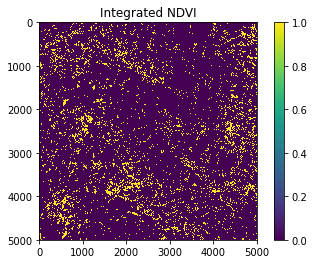

In [ ]:
# plot NDVI integral of one tile
plt.imshow(np_integrated_ndvi>=0.5,interpolation="none")
plt.colorbar()
plt.title('Integrated NDVI')

Text(0.5, 1.0, 'Kmeans clustering result')

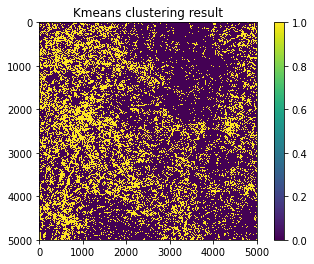

In [43]:
# plot clustering result of one tile
plt.imshow(labels==1,interpolation="none")
plt.colorbar()
plt.title('Kmeans clustering result')

Text(0.5, 1.0, 'DEM slope')

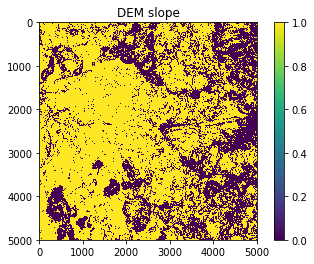

In [44]:
# plot DEM slope of one tile
plt.imshow(np_dem_slope<=10,interpolation="none")
plt.colorbar()
plt.title('DEM slope')

Text(0.5, 1.0, 'irrigated cropland mask')

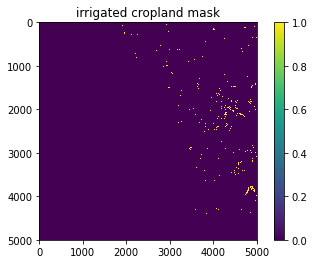

In [45]:
# plot irrigated cropland mask of one tile
plt.imshow(irrigated_mask,interpolation="none")
plt.colorbar()
plt.title('irrigated cropland mask')

Text(0.5, 1.0, 'filtered irrigated cropland mask')

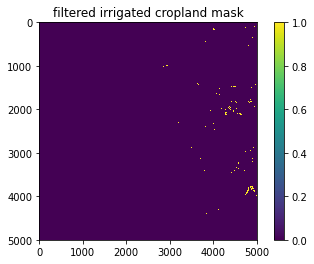

In [46]:
# plot filtered irrigated cropland mask (>=100 pixels) of one tile
plt.imshow(irrigated_mask_filtered==1,interpolation="none")
plt.colorbar()
plt.title('filtered irrigated cropland mask')